# Quickstart
## Obtaining statistics
In order to obtain statistics from coalescent distributions, we first need to define such a distribution. This is done by creating a {class}`~phasegen.distributions.Coalescent` object which serves as an entry point from which all statistics can be obtained. Below is an example of a simple Kingman coalescent distribution with ``n=10`` lineages, and a single population of constant size 1.

In [1]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [4.4, 3.3]

In [2]:
import phasegen as pg

coal = pg.Coalescent(
    n=10,
    demography=pg.Demography(
        pop_sizes=1
    )
)

We can now access various statistics from this distribution which are made available as cached properties of the component distribution of the {class}`~phasegen.distributions.Coalescent` object:

In [3]:
# mean coalescence time or tree height
coal.tree_height.mean

1.8000000000000003

In [4]:
# variance of the coalescence time
coal.tree_height.var

1.1581418493323286

In [5]:
# expected total branch length
coal.total_branch_length.mean

5.657936507936511

<Figure size 440x330 with 0 Axes>

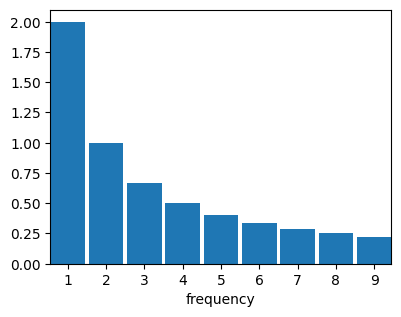

In [6]:
# expected site-frequency spectrum
coal.sfs.mean.plot();

In fact, `coal.tree_height`, `coal.total_branch_length`, and `coal.sfs` are all {class}`~phasegen.distributions.PhaseTypeDistribution` objects which can be accessed to obtain statistics on these distributions. If you would like to take a closer look at the API reference, these are {class}`~phasegen.distributions.TreeHeightDistribution`, {class}`~phasegen.distributions.PhaseTypeDistribution`, and {class}`~phasegen.distributions.UnfoldedSFSDistribution`, respectively. {class}`~phasegen.distributions.PhaseTypeDistribution` instances support the computation of moments and cross-moments of arbitrary order, which is only limited by the computational burden associated with higher-order moments. {class}`~phasegen.distributions.TreeHeightDistribution` extends {class}`~phasegen.distributions.PhaseTypeDistribution` and offers additional information through the PDF, CDF and quantile function.

In [7]:
coal.tree_height.quantile(0.95)

3.89324951171875

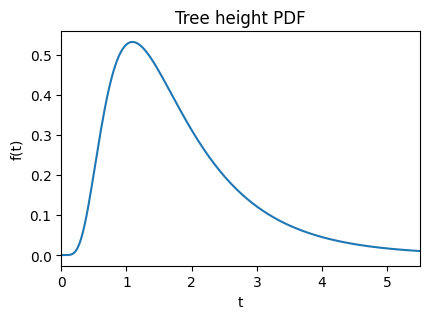

In [8]:
coal.tree_height.plot_pdf();

Before we discuss on how to obtain more complex statistics, let us first define a more complex coalescent distribution. Here, we define a two-population coalescent using the {class}`~phasegen.coalescent_models.BetaCoalescent` model, where the population sizes and migration rates are time-dependent. The nested dictionaries under `pop_sizes` and `migration_rates` define the population name and times at which the population sizes and migration rates change.

In [9]:
coal = pg.Coalescent(
    n=pg.LineageConfig({'pop_0': 3, 'pop_1': 5}),
    model=pg.BetaCoalescent(alpha=1.7),
    demography=pg.Demography(
        pop_sizes={
            'pop_1': {0: 1.2, 5: 0.1, 5.5: 0.8},
            'pop_0': {0: 1.0}
        },
        migration_rates={
            ('pop_0', 'pop_1'): {0: 0.2, 8: 0.3},
            ('pop_1', 'pop_0'): {0: 0.5}
        }
    )
)

We can visualize the demography of this coalescent distribution (see {meth}`~phasegen.distributions.demography.plot`) which will plot the population sizes and migration rates as a function of time. ``pop_1`` experiences a bottleneck at time 5, and there is continuous migration between the two populations.

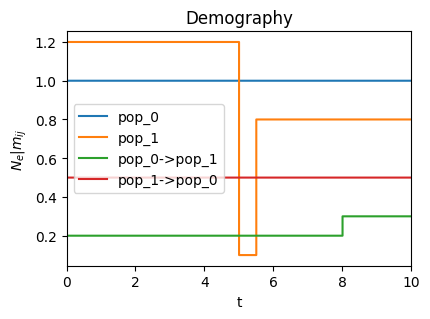

In [10]:
coal.demography.plot();

Let's take a look at the density of the underlying {class}`~phasegen.distributions.TreeHeightDistribution`.

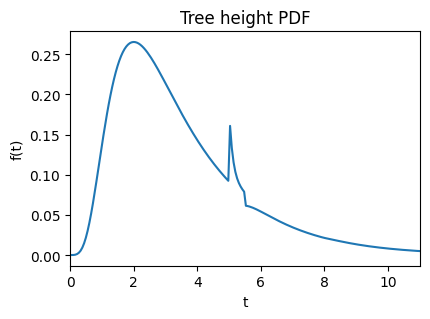

In [11]:
coal.tree_height.plot_pdf();

We can also compute higher-order moments of the SFS, such as the branch length correlation between branches subtending different numbers of lineages in the coalescent tree.

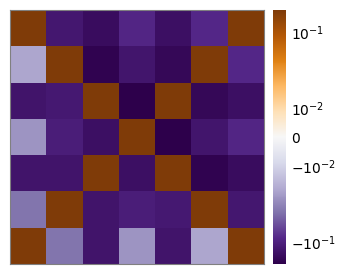

In [12]:
coal.sfs.corr.plot();

We may also marginalize over a single population. Here we obtain the mean SFS of ``pop_0``, which represents the branch lengths for lineages that subtends ``i`` lineages in the coalescent tree, while spending time in population ``pop_0``.

<Figure size 440x330 with 0 Axes>

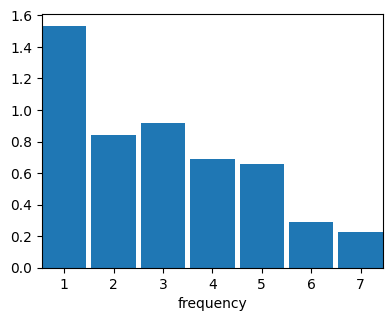

In [13]:
coal.sfs.demes['pop_0'].mean.plot();

In the {doc}`rewards` section, you can read more about how to obtain more complex moments by means of specifying rewards.

## Inferring parameters
The availability of exact moments lends itself to gradient-based parameter estimation. This is commonly done based on the SFS, but higher-order moments are also thinkable, provided they can be computed from the data at hand. ``phasegen`` provides a lightweight framework for performing parameter inference which is done by defining an {class}`~phasegen.inference.Inference` object. {class}`~phasegen.inference.Inference` requires a parametrized coalescent distribution, a loss function, and parameter bounds to be specified. More specifically, the `coal` argument is a callable that returns a {class}`~phasegen.distributions.Coalescent` object, based on the parameter values of the current optimization step, and `loss` is a callable specifying the current loss. By default, 10 independent optimization runs are performed using the L-BFGS-B algorithm, and the best result is returned. 

Below we optimize a one-epoch demography with a single population size change where the time of change (``t``) as well as the resulting population size (``Ne``) are variable. The observed summary statistics is an SFS with a sample size of 10, and the loss function is the Poisson likelihood.

In [14]:
observation = pg.SFS(
    [177130, 997, 441, 228, 156, 117, 114, 83, 105, 109, 652]
)

inf = pg.Inference(
    bounds=dict(t=(0, 4), Ne=(0.1, 1)),
    coal=lambda t, Ne: pg.Coalescent(
        n=10,
        demography=pg.Demography(
            pop_sizes={'pop_0': {0: 1, t: Ne}}
        )
    ),
    loss=lambda coal, _: pg.PoissonLikelihood().compute(
        observed=observation.normalize().polymorphic,
        modelled=coal.sfs.mean.normalize().polymorphic
    )
)

Upon construction, the inference object is ready to be optimized and the result can be visualized.

In [15]:
inf.run()

Optimizing: 100%|██████████| 10/10 [00:42<00:00,  4.22s/it]
INFO:Inference: Inferred parameters: (t=0.1455, Ne=0.4813)


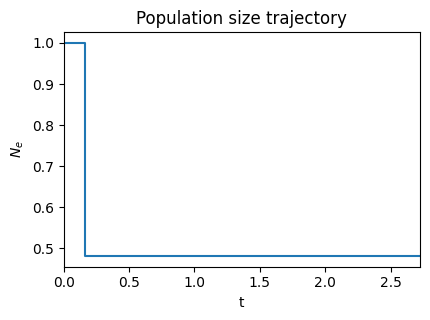

In [16]:
inf.plot_pop_sizes();

We may also wish to perform parametric bootstrapping. In order to do this, we provide a callback function to resample the data, and set `do_bootstrap=True`. Note that we specify {attr}`~phasegen.inference.Inference.observation` to {class}`~phasegen.inference.Inference`, which is necessary for the resampling to work.

In [17]:
inf = pg.Inference(
    bounds=dict(t=(0, 4), Ne=(0.1, 1)),
    observation=pg.SFS(
        [177130, 997, 441, 228, 156, 117, 114, 83, 105, 109, 652]
    ),
    coal=lambda t, Ne: pg.Coalescent(
        n=10,
        demography=pg.Demography(
            pop_sizes={'pop_0': {0: 1, t: Ne}}
        )
    ),
    loss=lambda coal, obs: pg.PoissonLikelihood().compute(
        observed=obs.normalize().polymorphic,
        modelled=coal.sfs.mean.normalize().polymorphic
    ),
    resample=lambda sfs, _: sfs.resample(),
    do_bootstrap=True
)

Let's run the inference again and visualize the results.

In [18]:
inf.run()

Optimizing: 100%|██████████| 10/10 [01:04<00:00,  6.46s/it]
INFO:Inference: Inferred parameters: (t=0.1455, Ne=0.4814)
Bootstrapping: 100%|██████████| 100/100 [02:47<00:00,  1.67s/it]


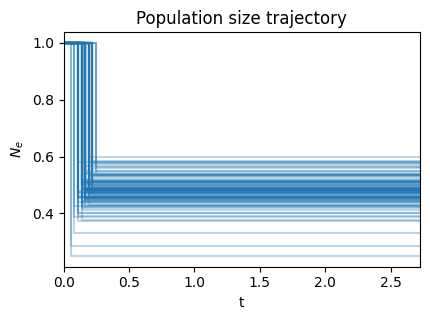

In [19]:
inf.plot_pop_sizes();

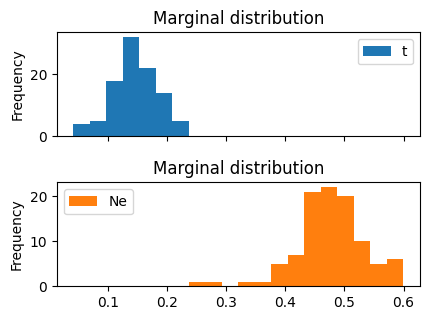

In [20]:
inf.plot_bootstraps();

You can read more about the inference process in the {doc}`inference` section.